<a href="https://colab.research.google.com/github/SLy-Precision/Player-Detection-and-Team-Performance-Prediction/blob/main/03_AEGIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 🎯 Optimization/Training/Validation of AEGIS (Adaptive Ensemble Game Insight Simulator) 🏛️ 🤖

### AEGIS is our method to PREDICT the performance of addition of new players in rosters of teams in Liga MX, AEGIS learns to play like complete team rosters through ensembled machine learning predictors inspired in LLM's (Check paper for more information and math background about it) 🧠

#### - Antonio Guerrero

In [ ]:
# Lets import the libraries we are gonna use 🐍

# Statsbomb api and more
!pip install --quiet statsbombpy
!pip install --quiet mplsoccer
!pip install --quiet highlight_text

# Libraries for the data manipulation and plot
from statsbombpy import sb
from tqdm import tqdm
import pandas as pd
from mplsoccer import VerticalPitch, Pitch, Sbapi
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import groupby
from mplsoccer import Pitch

# Machine Learning

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
# Lets get drive data (if u want to replicate use your directory)  🔵🔴🟡🟢

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Proyect_Hackathon/'


df = pd.read_csv(path + 'Full_Dataset_2021-2025.csv')
df_players = pd.read_csv(path + 'df_players_info_full.csv')
df_metrics = pd.read_csv(path + 'df_advanced_metrics.csv')

# Lets get the array of the match ids (Just in case)

#Credentials for Statsbomb from ITAM (Again, thanks ITAM 🟢)
user = "itam_hackathon@hudl.com"
password = "pGwIprel"

# Save info
array_season_2021_2022 = sb.matches(competition_id=73, season_id=108, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2022_2023 = sb.matches(competition_id=73, season_id=235, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2023_2024 = sb.matches(competition_id=73, season_id=281, creds={"user": user, "passwd": password})['match_id'].to_list()
array_season_2024_2025 = sb.matches(competition_id=73, season_id=317, creds={"user": user, "passwd": password})['match_id'].to_list()

# Create the training and validation ids

array_training = array_season_2021_2022 +  array_season_2022_2023 +  array_season_2023_2024
array_validation = array_season_2024_2025

# Lets see how many we got

print(f"We have {len(array_training)} matches for training and {len(array_validation)} for validation and fine tunning")

Mounted at /content/drive
We have 1024 matches for training and 340 for validation and fine tunning


#### 1) Preprocess and Prepare Data

In [ ]:
# First lets see the structure of the data

df.head()

,matchId,playerId,home_team_id,away_team_id,home_team_name,away_team_name,eventSec,EventTypeId,period,minute,...,TimeDelta,under_pressure,counterpress,IsPossessionWinningAction,IsDribbledPast,statsbomb_xg,xA,obv_total_net,gk_save_difficulty_xg,gk_xg_prevented
0,3799351,NaN,1297,1287,Guadalajara,Atlético San Luis,0.000,18,1,0,...,0.000,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,3799351,NaN,1297,1287,Guadalajara,Atlético San Luis,0.000,18,1,0,...,0.000,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,3799351,26311.0,1297,1287,Guadalajara,Atlético San Luis,1.057,30,1,0,...,1.057,0,0,0,0,NaN,NaN,0.005515,NaN,NaN
3,3799351,75306.0,1297,1287,Guadalajara,Atlético San Luis,2.349,42,1,0,...,1.292,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,3799351,75306.0,1297,1287,Guadalajara,Atlético San Luis,2.349,43,1,0,...,0.000,0,0,0,0,NaN,NaN,0.000413,NaN,NaN


In [ ]:
# Info of our dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4442402 entries, 0 to 4442401
Data columns (total 27 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   matchId                    int64  
 1   playerId                   float64
 2   home_team_id               int64  
 3   away_team_id               int64  
 4   home_team_name             object 
 5   away_team_name             object 
 6   eventSec                   float64
 7   EventTypeId                int64  
 8   period                     int64  
 9   minute                     int64  
 10  X                          float64
 11  Y                          float64
 12  IsHomeTeam                 int64  
 13  IsAccurate                 int64  
 14  IsGoal                     int64  
 15  HomeScore                  float64
 16  AwayScore                  float64
 17  TimeDelta                  float64
 18  under_pressure             int64  
 19  counterpress               int64  
 20  Is

In [ ]:
# Description of our dataset

df.describe()

,matchId,playerId,home_team_id,away_team_id,eventSec,EventTypeId,period,minute,X,Y,...,TimeDelta,under_pressure,counterpress,IsPossessionWinningAction,IsDribbledPast,statsbomb_xg,xA,obv_total_net,gk_save_difficulty_xg,gk_xg_prevented
count,4.442402e+06,4.422124e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.399722e+06,4.399722e+06,...,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,36521.000000,26351.000000,2.495820e+06,11902.000000,11902.000000
mean,3.885160e+06,5.368284e+04,1.342581e+03,1.344724e+03,1.451412e+03,3.208585e+01,1.493002e+00,4.586383e+01,4.851983e+01,5.013142e+01,...,1.862210e+00,2.047784e-01,3.441967e-02,3.893637e-02,5.298935e-03,0.097693,0.085393,1.560013e-03,0.292632,-0.013282
std,5.738300e+04,7.651336e+04,3.291541e+02,3.331546e+02,8.897301e+02,1.223413e+01,5.034383e-01,2.743781e+01,2.411336e+01,2.912169e+01,...,6.667942e+00,4.035396e-01,1.823046e-01,1.934434e-01,7.260067e-02,0.145614,0.107158,3.722873e-02,0.314822,0.340010
min,3.799351e+06,3.058000e+03,1.221000e+03,1.221000e+03,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,8.333333e-02,1.250000e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000180,0.002404,-1.094597e+00,0.000239,-0.999149
25%,3.835128e+06,2.636900e+04,1.227000e+03,1.227000e+03,6.716800e+02,3.000000e+01,1.000000e+00,2.200000e+01,3.050000e+01,2.475000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.025295,0.027333,-1.745542e-03,0.033654,-0.099253
50%,3.889664e+06,2.880200e+04,1.291000e+03,1.291000e+03,1.421354e+03,3.000000e+01,1.000000e+00,4.600000e+01,4.791667e+01,5.012500e+01,...,7.490000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.048520,0.050646,3.329026e-04,0.153887,0.022234
75%,3.939829e+06,3.787700e+04,1.300000e+03,1.300000e+03,2.214813e+03,4.200000e+01,2.000000e+00,6.800000e+01,6.691667e+01,7.562500e+01,...,1.631000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.096621,0.095679,3.809206e-03,0.485225,0.132393
max,3.995374e+06,4.740110e+05,2.773000e+03,2.773000e+03,4.771881e+03,4.300000e+01,5.000000e+00,1.290000e+02,1.007500e+02,1.000000e+02,...,1.860677e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.977087,0.977087,1.608129e+00,0.999679,0.991720


In [ ]:
# We dont need all the columns

columns = [
    'matchId', 'playerId', 'period', 'minute', 'X', 'Y',
    'EventTypeId', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
    'HomeScore', 'AwayScore', 'TimeDelta'
]

df = df[columns].copy()

In [ ]:
# Here we analize how to impute and what is best following the idea of Tiago Mendes Neves

# 1. Define the EventTypeIds for our stoppage or non-player events 📋
non_player_event_ids = [19, 18, 34, 27, 26, 24, 40, 36, 41]
event_map = {
    19: 'Substitution', 18: 'Half Start', 34: 'Half End',
    27: 'Player Off', 26: 'Player On', 24: 'Bad Behaviour',
    40: 'Injury Stoppage', 36: 'Tactical Shift', 41: 'Referee Ball-Drop'
}

# 2. Filter the DataFrame to get only these events 🔎
stoppage_df = df[df['EventTypeId'].isin(non_player_event_ids)].copy()

print("Analyzing Stoppage/Non-Player Events...")

if not stoppage_df.empty:
    # 3. Count how many of each event type we have 📊
    print("\n--- Count of Each Stoppage Event Type ---")
    # We map the IDs to names for better readability
    print(stoppage_df['EventTypeId'].map(event_map).value_counts())

    # 4. Check for null values in key columns 🧐
    print("\n--- Null Value Analysis (for Stoppage Events) ---")
    key_columns_to_check = ['playerId', 'X', 'Y']
    null_counts = stoppage_df[key_columns_to_check].isnull().sum()
    total_events = len(stoppage_df)

    for col in key_columns_to_check:
        print(f"Column '{col}': {null_counts[col]} null values out of {total_events} ({ (null_counts[col]/total_events)*100 :.2f}%)")

    # 5. Show a sample of the data for visual inspection 🔬
    print("\n--- Sample of Stoppage Events (first 10 rows) ---")
    # We select a wider range of columns to get the full picture
    sample_columns = ['EventTypeId', 'playerId', 'X', 'Y', 'period', 'minute', 'IsHomeTeam']
    print(stoppage_df[sample_columns].head(10))

else:
    print("No stoppage events found with the specified IDs.")

Analyzing Stoppage/Non-Player Events...

--- Count of Each Stoppage Event Type ---
EventTypeId
Substitution         12066
Injury Stoppage       9287
Half Start            5490
Half End              5490
Tactical Shift        4819
Referee Ball-Drop     4479
Player Off            1874
Player On             1854
Bad Behaviour         1789
Name: count, dtype: int64

--- Null Value Analysis (for Stoppage Events) ---
Column 'playerId': 20278 null values out of 47148 (43.01%)
Column 'X': 42669 null values out of 47148 (90.50%)
Column 'Y': 42669 null values out of 47148 (90.50%)

--- Sample of Stoppage Events (first 10 rows) ---
      EventTypeId  playerId   X   Y  period  minute  IsHomeTeam
0              18       NaN NaN NaN       1       0           1
1              18       NaN NaN NaN       1       0           0
1598           40   29267.0 NaN NaN       1      43           1
1697           34       NaN NaN NaN       1      48           1
1698           34       NaN NaN NaN       1      48

In [ ]:
df.describe()

,matchId,playerId,period,minute,X,Y,EventTypeId,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta
count,4.442402e+06,4.422124e+06,4.442402e+06,4.442402e+06,4.399722e+06,4.399722e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06,4.442402e+06
mean,3.885160e+06,5.368284e+04,1.493002e+00,4.586383e+01,4.851983e+01,5.013142e+01,3.208585e+01,5.124786e-01,2.274004e-01,8.196016e-04,6.589559e-01,5.148037e-01,1.862210e+00
std,5.738300e+04,7.651336e+04,5.034383e-01,2.743781e+01,2.411336e+01,2.912169e+01,1.223413e+01,4.998443e-01,4.191533e-01,2.861695e-02,9.142963e-01,8.010573e-01,6.667942e+00
min,3.799351e+06,3.058000e+03,1.000000e+00,0.000000e+00,8.333333e-02,1.250000e-01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.835128e+06,2.636900e+04,1.000000e+00,2.200000e+01,3.050000e+01,2.475000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.889664e+06,2.880200e+04,1.000000e+00,4.600000e+01,4.791667e+01,5.012500e+01,3.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.490000e-01
75%,3.939829e+06,3.787700e+04,2.000000e+00,6.800000e+01,6.691667e+01,7.562500e+01,4.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.631000e+00
max,3.995374e+06,4.740110e+05,5.000000e+00,1.290000e+02,1.007500e+02,1.000000e+02,4.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,8.000000e+00,1.860677e+03


In [ ]:
# 2. Smart Imputation for Stoppage / Non-Player Events 🧠
print("Step 2: Imputing stoppage/non-player events...")
non_player_event_ids = [19, 18, 34, 27, 26, 24, 40, 36, 41]
stoppage_mask = df['EventTypeId'].isin(non_player_event_ids)

print(f"Found and imputing {stoppage_mask.sum()} stoppage events.")
df.loc[stoppage_mask, 'X'] = 50.0
df.loc[stoppage_mask, 'Y'] = 50.0
df.loc[stoppage_mask, 'playerId'] = -1

# Generic fill for any remaining NaNs in 'IsAccurate'
df['IsAccurate'].fillna(0, inplace=True)

# 3. Final Cleaning: Remove the 11 orphan Goalkeeper events 🗑️
print("Step 3: Removing rows with remaining null coordinates...")
df.dropna(subset=['X', 'Y'], inplace=True)

# 4. Normalization ⚖️
print("Step 4: Normalizing all features...")
# Coordinates
df['X'] = np.clip(df['X'], 0, 100)
df['Y'] = np.clip(df['Y'], 0, 100)
df['X_norm'] = df['X'] / 100.0
df['Y_norm'] = df['Y'] / 100.0

# Time & Score
df['minute_norm'] = df['minute'] / 60.0
df['HomeScore_norm'] = df['HomeScore'] / 10.0
df['AwayScore_norm'] = df['AwayScore'] / 10.0

# 5. Final Verification ✅
print("\n✅ DataFrame 'df' is perfect.")
print("\nFinal check for null values:")
print(df.isnull().sum())

Step 2: Imputing stoppage/non-player events...
Found and imputing 47148 stoppage events.
Step 3: Removing rows with remaining null coordinates...


/tmp/ipython-input-2538229923.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['IsAccurate'].fillna(0, inplace=True)


Step 4: Normalizing all features...

✅ DataFrame 'df' is perfect.

Final check for null values:
matchId           0
playerId          0
period            0
minute            0
X                 0
Y                 0
EventTypeId       0
IsHomeTeam        0
IsAccurate        0
IsGoal            0
HomeScore         0
AwayScore         0
TimeDelta         0
X_norm            0
Y_norm            0
minute_norm       0
HomeScore_norm    0
AwayScore_norm    0
dtype: int64


In [ ]:
# Original paper has no pennalties neither extra time, so lets check how many events we loss

# 1. Count total events before filtering 📊
total_events_before = len(df)
print(f"Total events in the original DataFrame: {total_events_before}")

# 2. Apply the filter for regular time only ⏱️
df_filtered = df[df['period'] <= 2].copy()

# 3. Count events after filtering 📊
total_events_after = len(df_filtered)
print(f"Total events after removing extra time/penalties: {total_events_after}")

# 4. Calculate the difference ➖
events_removed = total_events_before - total_events_after
percentage_removed = (events_removed / total_events_before) * 100

print(f"\nEvents removed: {events_removed}")
print(f"Percentage of total events removed: {percentage_removed:.2f}%")

Total events in the original DataFrame: 4442391
Total events after removing extra time/penalties: 4439283

Events removed: 3108
Percentage of total events removed: 0.07%


In [ ]:
# To not lose the line

df = df_filtered.copy()

In [ ]:
# Lets make a last check of data to build the predictors of engine 🚀

print("--- 1. General Info & Null Count ---")
# This checks for nulls and confirms data types for all columns.
# We expect to see zero nulls and all data types as numbers (int or float).
df.info()

--- 1. General Info & Null Count ---
<class 'pandas.core.frame.DataFrame'>
Index: 4439283 entries, 0 to 4442401
Data columns (total 18 columns):
 #   Column          Dtype  
---  ------          -----  
 0   matchId         int64  
 1   playerId        float64
 2   period          int64  
 3   minute          int64  
 4   X               float64
 5   Y               float64
 6   EventTypeId     int64  
 7   IsHomeTeam      int64  
 8   IsAccurate      int64  
 9   IsGoal          int64  
 10  HomeScore       float64
 11  AwayScore       float64
 12  TimeDelta       float64
 13  X_norm          float64
 14  Y_norm          float64
 15  minute_norm     float64
 16  HomeScore_norm  float64
 17  AwayScore_norm  float64
dtypes: float64(11), int64(7)
memory usage: 643.5 MB


In [ ]:
print("--- 2. Statistical Summary ---")
# This gives us a statistical overview.
# We're checking if the min/max for normalized columns are correct
# and if the means/std deviations look reasonable.
print(df.describe())

--- 2. Statistical Summary ---
            matchId      playerId        period        minute             X  \
count  4.439283e+06  4.439283e+06  4.439283e+06  4.439283e+06  4.439283e+06   
mean   3.885167e+06  5.313001e+04  1.491450e+00  4.582060e+01  4.853511e+01   
std    5.738998e+04  7.633197e+04  4.999269e-01  2.739758e+01  2.398240e+01   
min    3.799351e+06 -1.000000e+00  1.000000e+00  0.000000e+00  8.333333e-02   
25%    3.835128e+06  2.636200e+04  1.000000e+00  2.200000e+01  3.075000e+01   
50%    3.889664e+06  2.876400e+04  1.000000e+00  4.600000e+01  4.825000e+01   
75%    3.939830e+06  3.774700e+04  2.000000e+00  6.800000e+01  6.675000e+01   
max    3.995374e+06  4.740110e+05  2.000000e+00  1.100000e+02  1.000000e+02   

                  Y   EventTypeId    IsHomeTeam    IsAccurate        IsGoal  \
count  4.439283e+06  4.439283e+06  4.439283e+06  4.439283e+06  4.439283e+06   
mean   5.013031e+01  3.208651e+01  5.124159e-01  2.273939e-01  8.044092e-04   
std    2.897300e+01 

In [ ]:
print("--- 3. Specific Check: playerId Integrity ---")
# A final confirmation that all playerId values are valid numbers.
invalid_player_ids = df['playerId'].isnull().sum()
if invalid_player_ids == 0:
    print("✅ SUCCESS: All rows have a valid 'playerId'.")
else:
    print(f"⚠️ WARNING: Found {invalid_player_ids} rows with null 'playerId'.")

--- 3. Specific Check: playerId Integrity ---
✅ SUCCESS: All rows have a valid 'playerId'.


In [ ]:
# Lets save the df for the model

df.to_csv('AEGIS_data.csv', index=False)

In [ ]:
# Lets save it directly in our drive

# df.to_csv(path + 'AEGIS_data.csv', index=False)

## Training, Optimization and Validation of the models for AEGIS

### 1) EventTypeId Forecast

In [ ]:
# Import data for the different models

df_AEGIS = pd.read_csv(path + 'AEGIS_data.csv')

In [ ]:
# Lets check integrity after save

df_AEGIS.describe()

# Nice ✅

,matchId,playerId,period,minute,X,Y,EventTypeId,IsHomeTeam,IsAccurate,IsGoal,HomeScore,AwayScore,TimeDelta,X_norm,Y_norm,minute_norm,HomeScore_norm,AwayScore_norm
count,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06,4.439283e+06
mean,3.885167e+06,5.313001e+04,1.491450e+00,4.582060e+01,4.853511e+01,5.013031e+01,3.208651e+01,5.124159e-01,2.273939e-01,8.044092e-04,6.582230e-01,5.144723e-01,1.861155e+00,4.853511e-01,5.013031e-01,7.636767e-01,6.582230e-02,5.144723e-02
std,5.738998e+04,7.633197e+04,4.999269e-01,2.739758e+01,2.398240e+01,2.897300e+01,1.223411e+01,4.998459e-01,4.191491e-01,2.835070e-02,9.139417e-01,8.003922e-01,6.663709e+00,2.398240e-01,2.897300e-01,4.566263e-01,9.139417e-02,8.003922e-02
min,3.799351e+06,-1.000000e+00,1.000000e+00,0.000000e+00,8.333333e-02,1.250000e-01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.333333e-04,1.250000e-03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.835128e+06,2.636200e+04,1.000000e+00,2.200000e+01,3.075000e+01,2.512500e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.075000e-01,2.512500e-01,3.666667e-01,0.000000e+00,0.000000e+00
50%,3.889664e+06,2.876400e+04,1.000000e+00,4.600000e+01,4.825000e+01,5.000000e+01,3.000000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.490000e-01,4.825000e-01,5.000000e-01,7.666667e-01,0.000000e+00,0.000000e+00
75%,3.939830e+06,3.774700e+04,2.000000e+00,6.800000e+01,6.675000e+01,7.525000e+01,4.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.631000e+00,6.675000e-01,7.525000e-01,1.133333e+00,1.000000e-01,1.000000e-01
max,3.995374e+06,4.740110e+05,2.000000e+00,1.100000e+02,1.000000e+02,1.000000e+02,4.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00,8.000000e+00,1.860677e+03,1.000000e+00,1.000000e+00,1.833333e+00,8.000000e-01,8.000000e-01


In [ ]:
# 🚀 AEGIS EventTypeID Model Training Functions

# --- 💡 STEP 0: Create the Class Mapping ---
# Get all unique event types from the entire dataset
all_event_types = sorted(df['EventTypeId'].unique())
# Create a mapping from the original ID to a new, zero-indexed ID
class_mapping = {original_id: new_id for new_id, original_id in enumerate(all_event_types)}
num_classes = len(all_event_types)

print("--- Class Mapping Created ---")
print(f"Total unique event types (classes): {num_classes}")
print("This mapping will be used to encode the target variable.")


def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId', mapping=None):
    """
    Prepares a subset of the DataFrame for training by creating sequential context features.
    """
    print(f"Processing {len(match_ids)} matches to create context...")
    data = df[df['matchId'].isin(match_ids)].copy()

    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    data.fillna(-1, inplace=True)
    data.dropna(subset=[f'c{seq_len}_{context_features[0]}'], inplace=True)

    y = data[target_col]
    # 💡 CORRECTION: Apply the mapping to the target variable
    if mapping:
        y = y.map(mapping)

    features_to_drop = context_features + [target_col, 'matchId', 'playerId', 'X', 'Y',
                                           'minute', 'HomeScore', 'AwayScore', 'period']
    cols_to_drop_existing = [col for col in features_to_drop if col in data.columns]
    X = data.drop(columns=cols_to_drop_existing)

    return X, y

def train_event_type_model(df, train_ids, val_ids, num_classes, class_mapping, seq_len=5):
    """
    Trains the XGBoost model to predict the next event's type.
    """
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]

    # --- Prepare Data ---
    print("\nPreparing training and validation data...")
    X_train, y_train = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col='EventTypeId', mapping=class_mapping)
    X_val, y_val = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col='EventTypeId', mapping=class_mapping)

    # --- Train Model ---
    print("\nCalculating sample weights for class imbalance...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        # 💡 CORRECTION: Explicitly tell the model how many classes to expect
        num_class=num_classes,
        eval_metric='mlogloss',
        max_depth=7,
        learning_rate=0.05,
        use_label_encoder=False, # This is now very important
        n_estimators=1000,
        early_stopping_rounds=20,
        random_state=42
    )

    print("\nStarting model training...")
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights)

    # (The rest of the function for plotting results remains the same)
    # ...
    return model

--- Class Mapping Created ---
Total unique event types (classes): 32
This mapping will be used to encode the target variable.


In [ ]:
# Let see how many matches we have per array

print(f"We have {len(array_training)} matches for training and {len(array_validation)} for validation and fine tunning")

We have 1024 matches for training and 340 for validation and fine tunning


In [ ]:
# Start Training
event_type_model = train_event_type_model(df_AEGIS, array_training, array_validation, num_classes, class_mapping)


Preparing training and validation data...
Processing 1024 matches to create context...
Processing 340 matches to create context...

Calculating sample weights for class imbalance...

Starting model training...
[0]	validation_0-mlogloss:3.19112
[10]	validation_0-mlogloss:2.29003
[20]	validation_0-mlogloss:1.95776
[30]	validation_0-mlogloss:1.76873
[40]	validation_0-mlogloss:1.64725
[50]	validation_0-mlogloss:1.56871
[60]	validation_0-mlogloss:1.51295
[70]	validation_0-mlogloss:1.47011
[80]	validation_0-mlogloss:1.43904
[90]	validation_0-mlogloss:1.41568
[100]	validation_0-mlogloss:1.39748
[110]	validation_0-mlogloss:1.38298
[120]	validation_0-mlogloss:1.37147
[130]	validation_0-mlogloss:1.36207
[140]	validation_0-mlogloss:1.35423
[150]	validation_0-mlogloss:1.34759
[160]	validation_0-mlogloss:1.34137
[170]	validation_0-mlogloss:1.33568
[180]	validation_0-mlogloss:1.33082
[190]	validation_0-mlogloss:1.32646
[200]	validation_0-mlogloss:1.32211
[210]	validation_0-mlogloss:1.31827
[220]	va

In [ ]:
# Lets save the model 💾

event_type_model.save_model(path + 'event_type_model1.json')

In [ ]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score, classification_report

# ===================================================================
# 🚀 PHASE 2B: AEGIS EventType Predictor Evaluation
# ===================================================================

def evaluate_model_performance(model, X_val, y_val, class_mapping):
    """
    Calculates and displays detailed evaluation metrics for our classification model.
    """
    print("Making predictions on the validation set...")
    # y_val is already mapped, so we can use it directly
    y_pred_proba = model.predict_proba(X_val)
    y_pred = model.predict(X_val)

    # --- 1. Top-k Accuracy ---
    print("\n--- Top-k Accuracy ---")
    # This metric tells us how often the correct answer is within the model's top predictions.
    acc_top1 = top_k_accuracy_score(y_val, y_pred_proba, k=1)
    print(f"🎯 Top-1 Accuracy (Standard Accuracy): {acc_top1:.4f}")
    acc_top3 = top_k_accuracy_score(y_val, y_pred_proba, k=3)
    print(f"🎯 Top-3 Accuracy (Correct answer is in the Top 3): {acc_top3:.4f}")

    # --- 2. Classification Report by Class ---
    print("\n--- Classification Report by Class ---")

    # 💡 ADAPTATION: We need to create the class names based on our specific data.
    # First, create a reverse mapping from the new ID back to the original EventTypeId
    reverse_mapping = {v: k for k, v in class_mapping.items()}

    # Then, create a dictionary from original EventTypeId to its name (from data_information.pdf)
    event_name_map = {
        18: 'Half Start', 30: 'Pass', 42: 'Ball Receipt*', 43: 'Carry', 17: 'Pressure',
        14: 'Dribble', 4: 'Duel', 9: 'Clearance', 3: 'Dispossessed', 2: 'Ball Recovery',
        6: 'Block', 22: 'Foul Committed', 21: 'Foul Won', 16: 'Shot', 23: 'Goal Keeper',
        39: 'Dribbled Past', 38: 'Miscontrol', 27: 'Player Off', 26: 'Player On',
        10: 'Interception', 33: '50/50', 34: 'Half End', 40: 'Injury Stoppage',
        19: 'Substitution', 36: 'Tactical Shift', 24: 'Bad Behaviour', 41: 'Referee Ball-Drop',
        37: 'Error', 28: 'Shield', 8: 'Offside', 25: 'Own Goal For', 20: 'Own Goal Against'
    }

    # Create the list of target names in the correct order of our mapped classes (0, 1, 2...)
    # We handle cases where an event ID might not be in our name map
    target_names = [event_name_map.get(reverse_mapping[i], f"Unknown_ID_{reverse_mapping[i]}") for i in range(len(class_mapping))]

    report = classification_report(y_val, y_pred, target_names=target_names, zero_division=0)
    print(report)

In [ ]:
print("Starting model evaluation...")

import xgboost as xgb

# ===================================================================
# 🚀 PHASE 2B: Evaluating from a Saved Model
# ===================================================================

# --- Step 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS model from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ Model loaded successfully!")


# --- Step 2: Re-generate the Validation Data ---
print("\nStep 2: Re-generating the validation data (X_val, y_val)... 🧑‍🍳")

# We use the same function as before, but only for the validation set.
# This ensures we have the exact data the model needs for evaluation.
# (Make sure 'df', 'array_validation', and 'class_mapping' are available in your notebook)

X_val, y_val = prepare_data_for_matches(
    df_AEGIS,
    match_ids=array_validation,
    seq_len=5,
    context_features=[
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ],
    target_col='EventTypeId',
    mapping=class_mapping
)

print("✅ Validation data is ready!")


# --- Step 3: Evaluate the Model! ---
print("\nStep 3: Starting model evaluation...")

# Now that the model and the data are back in memory, this will work perfectly
evaluate_model_performance(
    model=event_type_model,
    X_val=X_val,
    y_val=y_val,
    class_mapping=class_mapping
)

Starting model evaluation...
Step 1: Loading the trained AEGIS model from file... 📂
✅ Model loaded successfully!

Step 2: Re-generating the validation data (X_val, y_val)... 🧑‍🍳
Processing 340 matches to create context...
✅ Validation data is ready!

Step 3: Starting model evaluation...
Making predictions on the validation set...

--- Top-k Accuracy ---
🎯 Top-1 Accuracy (Standard Accuracy): 0.6245
🎯 Top-3 Accuracy (Correct answer is in the Top 3): 0.8457

--- Classification Report by Class ---
                   precision    recall  f1-score   support

    Ball Recovery       0.82      0.78      0.80     32434
     Dispossessed       0.55      0.57      0.56      8526
             Duel       0.38      0.52      0.44     21569
            Block       0.19      0.60      0.29     13163
          Offside       0.01      0.09      0.02       140
        Clearance       0.24      0.60      0.34     13234
     Interception       0.28      0.70      0.40      5606
          Dribble       0.81

### 2) IsAccurate Forecast

In [ ]:
df_AEGIS = pd.read_csv(path + 'AEGIS_data.csv')

In [ ]:
# --- Step 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS model from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ Model loaded successfully!")

Step 1: Loading the trained AEGIS model from file... 📂
✅ Model loaded successfully!


In [ ]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

# ===================================================================
# 🚀 PHASE 3A: AEGIS 'IsAccurate' Predictor Training
# ===================================================================

def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId', mapping=None):
    """
    Prepares a subset of the DataFrame for training by creating sequential context features.
    """
    print(f"Processing {len(match_ids)} matches to create context...")
    data = df[df['matchId'].isin(match_ids)].copy()

    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    data.fillna(-1, inplace=True)
    data.dropna(subset=[f'c{seq_len}_{context_features[0]}'], inplace=True)

    y = data[target_col]
    # 💡 CORRECTION: Apply the mapping to the target variable
    if mapping:
        y = y.map(mapping)

    features_to_drop = context_features + [target_col, 'matchId', 'playerId', 'X', 'Y',
                                           'minute', 'HomeScore', 'AwayScore', 'period']
    cols_to_drop_existing = [col for col in features_to_drop if col in data.columns]
    X = data.drop(columns=cols_to_drop_existing)

    return X, y

def prepare_data_with_predicted_event(df, match_ids, seq_len, context_features, event_type_model, target_col='IsAccurate'):
    """
    Prepares data by creating the 5-event context AND adding the predicted event type as a new feature.
    """
    # Step 1: Create the base X and y for the given matches
    # We pass a dummy mapping because we're not using the mapped 'y' here
    X, y_target = prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col=target_col, mapping={})

    # Step 2: Use the trained event_type_model to make predictions on this data
    print(f"Generating EventType predictions for {len(X)} rows...")
    predicted_event_type = event_type_model.predict(X)

    # Step 3: Add the prediction as a new feature to X
    X['predicted_EventTypeId'] = predicted_event_type

    print("✅ Context enriched with predicted EventType.")
    return X, y_target


def train_accuracy_model(df, train_ids, val_ids, event_type_model, seq_len=5):
    """
    Trains the XGBoost model to predict 'IsAccurate'.
    """
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]

    # --- Prepare Data (with the new enriched context function) ---
    print("Preparing training and validation data for Accuracy model...")
    X_train, y_train = prepare_data_with_predicted_event(df, train_ids, seq_len, context_features, event_type_model, target_col='IsAccurate')
    X_val, y_val = prepare_data_with_predicted_event(df, val_ids, seq_len, context_features, event_type_model, target_col='IsAccurate')

    # --- Train Model ---
    print("\nCalculating sample weights for class imbalance...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # 💡 CHANGE: The objective is now 'binary:logistic' for a 0/1 prediction
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss', # Logloss is also the standard for binary
        max_depth=7, # We can start with a slightly smaller depth
        learning_rate=0.05,
        use_label_encoder=False,
        n_estimators=1000,
        early_stopping_rounds=20,
        random_state=42
    )

    print("\nStarting 'IsAccurate' model training...")
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=10,
              sample_weight=sample_weights)

    print(f"\nTraining complete! Best iteration: {model.best_iteration}")

    # (Plotting code would be very similar, showing binary logloss)
    # ...

    return model

In [ ]:
accuracy_model = train_accuracy_model(
     df_AEGIS,
     train_ids=array_training,
     val_ids=array_validation,
     event_type_model=event_type_model
     )

Preparing training and validation data for Accuracy model...
Processing 1024 matches to create context...
Generating EventType predictions for 3284059 rows...
✅ Context enriched with predicted EventType.
Processing 340 matches to create context...
Generating EventType predictions for 1155224 rows...
✅ Context enriched with predicted EventType.

Calculating sample weights for class imbalance...

Starting 'IsAccurate' model training...
[0]	validation_0-logloss:0.67208
[10]	validation_0-logloss:0.54162
[20]	validation_0-logloss:0.48478
[30]	validation_0-logloss:0.45848
[40]	validation_0-logloss:0.44360
[50]	validation_0-logloss:0.43631
[60]	validation_0-logloss:0.43165
[70]	validation_0-logloss:0.42860
[80]	validation_0-logloss:0.42650
[90]	validation_0-logloss:0.42536
[100]	validation_0-logloss:0.42442
[110]	validation_0-logloss:0.42381
[120]	validation_0-logloss:0.42339
[130]	validation_0-logloss:0.42282
[140]	validation_0-logloss:0.42231
[150]	validation_0-logloss:0.42188
[160]	validat

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

# ===================================================================
# 🚀 Advanced Evaluation for Binary Classification Models
# ===================================================================

def evaluate_binary_model(model, X_val, y_val, model_name='Model'):
    """
    Calculates and displays advanced evaluation metrics for a binary classification model.
    """
    print(f"--- Evaluating Performance for: {model_name} ---")

    # --- 1. Predictions ---
    print("\nStep 1: Making predictions on the validation set...")
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] # Probabilities for the positive class (1)

    # --- 2. General Results (Classification Report) ---
    print("\n--- 2. General Classification Report ---")
    # This gives you precision, recall, and f1-score for both classes (0 and 1)
    report = classification_report(y_val, y_pred, target_names=['Inaccurate (0)', 'Accurate (1)'])
    print(report)

    # --- 3. Confusion Matrix ---
    print("\n--- 3. Confusion Matrix ---")
    # This shows you True Positives, False Positives, True Negatives, and False Negatives
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Inaccurate', 'Predicted Accurate'],
                yticklabels=['Actual Inaccurate', 'Actual Accurate'])
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 4. ROC Curve and AUC Score ---
    print("\n--- 4. ROC Curve & AUC Score ---")
    # This shows the model's ability to distinguish between classes
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC (Area Under Curve) Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:
# Save model

accuracy_model.save_model(path + 'accuracy_model1.json')

In [ ]:
import xgboost as xgb

# ===================================================================
# 🚀 Evaluating the 'IsAccurate' Model After a Session Restart
# ===================================================================

# --- Step 1: Load BOTH Trained Models ---
print("Step 1: Loading trained models from files... 📂")

# --- Step 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS model from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ Model loaded successfully!")

# Load the IsAccurate model
accuracy_model = xgb.XGBClassifier()

model_filename = path + 'accuracy_model1.json'

# Load the trained state into the empty model
accuracy_model.load_model(model_filename)


print("✅ Model loaded successfully!")


# --- Step 2: Re-generate the Enriched Validation Data ---
print("\nStep 2: Re-generating the enriched validation data for the 'IsAccurate' model... 🧑‍🍳")

# We use our specific function that adds the prediction from the first model as a feature.
# (Make sure 'df', 'array_validation', and the 'prepare_data_with_predicted_event' function are defined)
X_val_accuracy, y_val_accuracy = prepare_data_with_predicted_event(
    df_AEGIS,
    match_ids=array_validation,
    seq_len=5,
    context_features=[
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ],
    event_type_model=event_type_model,
    target_col='IsAccurate'
)

print("✅ Enriched validation data is ready!")


Step 1: Loading trained models from files... 📂
Step 1: Loading the trained AEGIS model from file... 📂
✅ Model loaded successfully!
✅ Model loaded successfully!

Step 2: Re-generating the enriched validation data for the 'IsAccurate' model... 🧑‍🍳
Processing 340 matches to create context...
Generating EventType predictions for 1155224 rows...
✅ Context enriched with predicted EventType.
✅ Enriched validation data is ready!



Step 3: Starting 'IsAccurate' model evaluation...
--- Evaluating Performance for: 'IsAccurate' Predictor ---

Step 1: Making predictions on the validation set...

--- 2. General Classification Report ---
                precision    recall  f1-score   support

Inaccurate (0)       0.95      0.78      0.85    887421
  Accurate (1)       0.54      0.87      0.66    267803

      accuracy                           0.80   1155224
     macro avg       0.74      0.82      0.76   1155224
  weighted avg       0.86      0.80      0.81   1155224


--- 3. Confusion Matrix ---


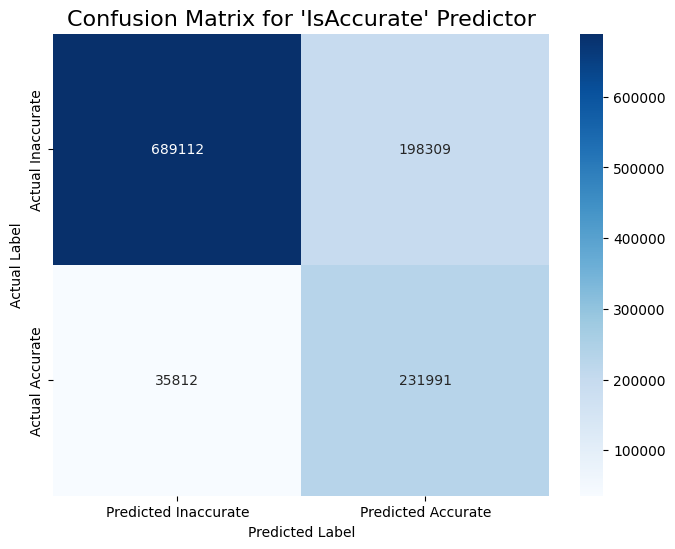


--- 4. ROC Curve & AUC Score ---
AUC (Area Under Curve) Score: 0.8970


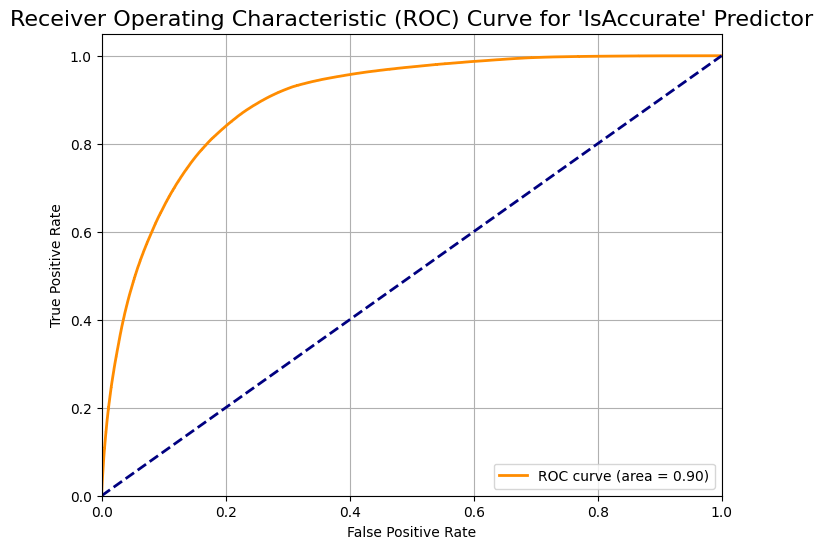

In [ ]:
# --- Step 3: Evaluate the Model! ---
print("\nStep 3: Starting 'IsAccurate' model evaluation...")

# Now this will work perfectly, using the correct model and the correct data
evaluate_binary_model(
    model=accuracy_model,
    X_val=X_val_accuracy,
    y_val=y_val_accuracy,
    model_name="'IsAccurate' Predictor"
)

#### 3) IsGoal Forecast

In [ ]:
df_AEGIS = pd.read_csv(path + 'AEGIS_data.csv')

In [ ]:
# --- Step 1: Load the Trained Model from the JSON File ---
print("Step 1: Loading the trained AEGIS model from file... 📂")

# Create a new, empty XGBoost model instance
event_type_model = xgb.XGBClassifier()

model_filename = path + 'event_type_model1.json'

# Load the trained state into the empty model
event_type_model.load_model(model_filename)

print("✅ Model loaded successfully!")

Step 1: Loading the trained AEGIS model from file... 📂
✅ Model loaded successfully!


In [ ]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ===================================================================
# 🚀 PHASE 4A: AEGIS 'IsGoal' Predictor Training (Specialist Model)
# ===================================================================

def prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col='EventTypeId', mapping=None):
    """
    Prepares a subset of the DataFrame for training by creating sequential context features.
    """
    print(f"Processing {len(match_ids)} matches to create context...")
    data = df[df['matchId'].isin(match_ids)].copy()

    for i in range(1, seq_len + 1):
        for feature in context_features:
            new_col_name = f'c{i}_{feature}'
            data[new_col_name] = data.groupby('matchId')[feature].shift(i)

    data.fillna(-1, inplace=True)
    data.dropna(subset=[f'c{seq_len}_{context_features[0]}'], inplace=True)

    y = data[target_col]
    # 💡 CORRECTION: Apply the mapping to the target variable
    if mapping:
        y = y.map(mapping)

    features_to_drop = context_features + [target_col, 'matchId', 'playerId', 'X', 'Y',
                                           'minute', 'HomeScore', 'AwayScore', 'period']
    cols_to_drop_existing = [col for col in features_to_drop if col in data.columns]
    X = data.drop(columns=cols_to_drop_existing)

    return X, y

def prepare_data_with_predicted_event(df, match_ids, seq_len, context_features, event_type_model, target_col='IsAccurate'):
    """
    Prepares data by creating the 5-event context AND adding the predicted event type as a new feature.
    """
    # Step 1: Create the base X and y for the given matches
    # We pass a dummy mapping because we're not using the mapped 'y' here
    X, y_target = prepare_data_for_matches(df, match_ids, seq_len, context_features, target_col=target_col, mapping={})

    # Step 2: Use the trained event_type_model to make predictions on this data
    print(f"Generating EventType predictions for {len(X)} rows...")
    predicted_event_type = event_type_model.predict(X)

    # Step 3: Add the prediction as a new feature to X
    X['predicted_EventTypeId'] = predicted_event_type

    print("✅ Context enriched with predicted EventType.")
    return X, y_target

def evaluate_binary_model(model, X_val, y_val, model_name='Model'):
    """
    Calculates and displays advanced evaluation metrics for a binary classification model.
    """
    print(f"--- Evaluating Performance for: {model_name} ---")

    # --- 1. Predictions ---
    print("\nStep 1: Making predictions on the validation set...")
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] # Probabilities for the positive class (1)

    # --- 2. General Results (Classification Report) ---
    print("\n--- 2. General Classification Report ---")
    # This gives you precision, recall, and f1-score for both classes (0 and 1)
    report = classification_report(y_val, y_pred, target_names=['Inaccurate (0)', 'Accurate (1)'])
    print(report)

    # --- 3. Confusion Matrix ---
    print("\n--- 3. Confusion Matrix ---")
    # This shows you True Positives, False Positives, True Negatives, and False Negatives
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Inaccurate', 'Predicted Accurate'],
                yticklabels=['Actual Inaccurate', 'Actual Accurate'])
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 4. ROC Curve and AUC Score ---
    print("\n--- 4. ROC Curve & AUC Score ---")
    # This shows the model's ability to distinguish between classes
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC (Area Under Curve) Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}', fontsize=16)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def train_goal_model(df, train_ids, val_ids, event_type_model, seq_len=5):
    """
    Trains a specialist XGBoost model to predict 'IsGoal' ONLY for shots.
    """
    context_features = [
        'EventTypeId', 'X_norm', 'Y_norm', 'IsHomeTeam', 'IsAccurate', 'IsGoal',
        'TimeDelta', 'minute_norm', 'HomeScore_norm', 'AwayScore_norm'
    ]

    # --- Prepare Data (with the enriched context) ---
    print("Preparing training and validation data for Goal model...")
    # We still need the full context to get the predicted EventType
    X_train_full, y_train_full = prepare_data_with_predicted_event(df, train_ids, seq_len, context_features, event_type_model, target_col='IsGoal')
    X_val_full, y_val_full = prepare_data_with_predicted_event(df, val_ids, seq_len, context_features, event_type_model, target_col='IsGoal')

    # --- 💡 YOUR KEY IDEA: Filter for Shots Only ---
    print("\nFiltering data to train only on 'Shot' events...")

    # We need the original EventTypeId for this. Let's get it.
    # We need to run prepare_data_for_matches again just to get the original EventTypeId column aligned.
    _, y_train_event_type = prepare_data_for_matches(df, train_ids, seq_len, context_features, target_col='EventTypeId')
    _, y_val_event_type = prepare_data_for_matches(df, val_ids, seq_len, context_features, target_col='EventTypeId')

    shot_event_id = 16

    # Filter the training data
    train_shot_mask = (y_train_event_type == shot_event_id)
    X_train_shots = X_train_full[train_shot_mask]
    y_train_shots = y_train_full[train_shot_mask]

    # Filter the validation data
    val_shot_mask = (y_val_event_type == shot_event_id)
    X_val_shots = X_val_full[val_shot_mask]
    y_val_shots = y_val_full[val_shot_mask]

    print(f"Training on {len(X_train_shots)} shots. Validating on {len(X_val_shots)} shots.")

    # --- Train Specialist Model ---
    print("\nCalculating sample weights for the goal/no-goal imbalance...")
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_shots)

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=4, # A smaller depth can work well for this specialist task
        learning_rate=0.05,
        use_label_encoder=False,
        n_estimators=500, # May not need as many estimators
        early_stopping_rounds=30,
        random_state=42
    )

    print("\nStarting 'IsGoal' specialist model training...")
    model.fit(X_train_shots, y_train_shots,
              eval_set=[(X_val_shots, y_val_shots)],
              verbose=100,
              sample_weight=sample_weights)

    print(f"\nTraining complete! Best iteration: {model.best_iteration}")

    evaluate_binary_model(model, X_val_shots, y_val_shots, model_name="'IsGoal' Specialist Predictor")

    return model

Preparing training and validation data for Goal model...
Processing 1024 matches to create context...
Generating EventType predictions for 3284059 rows...
✅ Context enriched with predicted EventType.
Processing 340 matches to create context...
Generating EventType predictions for 1155224 rows...
✅ Context enriched with predicted EventType.

Filtering data to train only on 'Shot' events...
Processing 1024 matches to create context...
Processing 340 matches to create context...
Training on 27425 shots. Validating on 8970 shots.

Calculating sample weights for the goal/no-goal imbalance...

Starting 'IsGoal' specialist model training...
[0]	validation_0-logloss:0.68719
[100]	validation_0-logloss:0.57755
[200]	validation_0-logloss:0.55476
[300]	validation_0-logloss:0.53710
[400]	validation_0-logloss:0.52247
[499]	validation_0-logloss:0.51040

Training complete! Best iteration: 499
--- Evaluating Performance for: 'IsGoal' Specialist Predictor ---

Step 1: Making predictions on the validatio

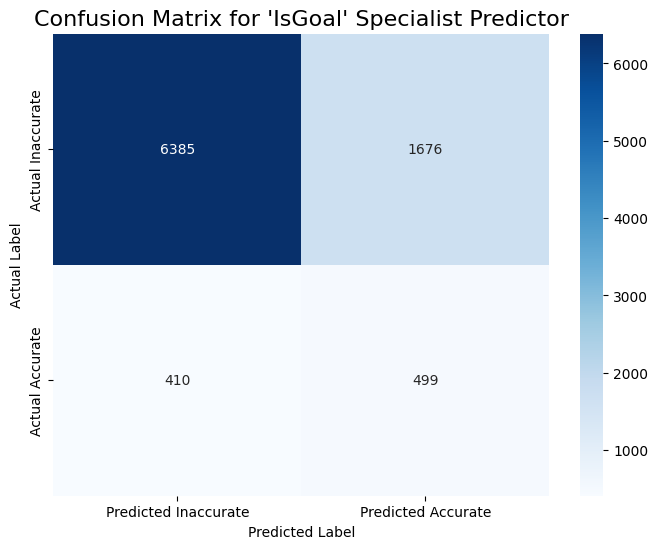


--- 4. ROC Curve & AUC Score ---
AUC (Area Under Curve) Score: 0.7309


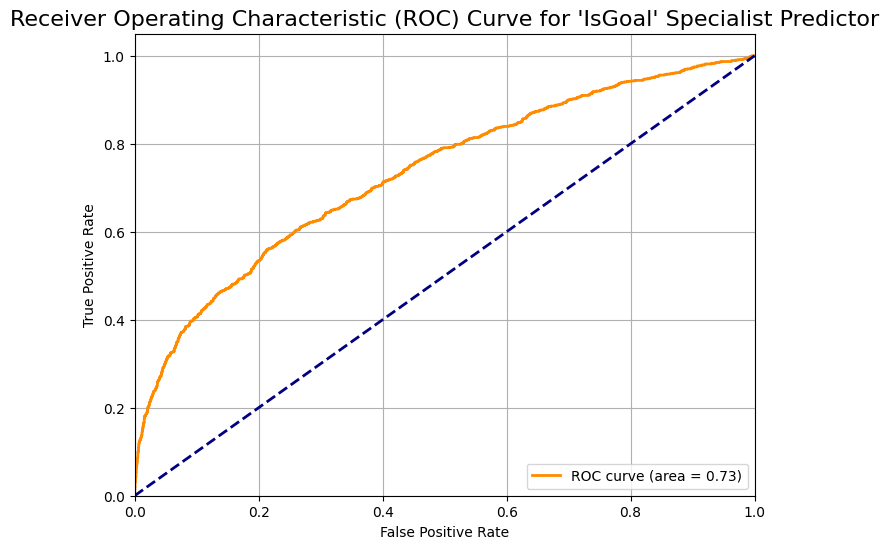

In [ ]:
goal_model = train_goal_model(
     df_AEGIS,
     train_ids=array_training,
     val_ids=array_validation,
     event_type_model=event_type_model
     )